In [1]:
import numpy as np
from os import listdir
from sklearn import svm,datasets,metrics
import os
import h5py
import cv2
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import glob
import warnings
from skimage.feature import local_binary_pattern
# To calculate a normalized histogram 
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize
# Utility package -- use pip install cvutils to install
import cvutils
# To read class from file
import csv
 





C:\Users\Harshini\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Harshini\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Harshini\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Harshini\AppData\R

In [2]:
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
from skimage import io, util
from skimage.feature.texture import greycomatrix, greycoprops



C:\Users\Harshini\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#initialze the variables

default_image_size = tuple((256, 256))
directory_root = '../mlapp/leafimages/'
bins=8
h5_data          = 'data.h5'
h5_labels        = 'labels.h5'
num_trees = 100
test_size = 0.10
seed      = 9
train_path = "leafimages"
test_path  = "test"
h5_data    = 'data.h5'
h5_labels  = 'labels.h5'
scoring    = "accuracy"


In [4]:
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [5]:
#Function to convert images to array

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


In [6]:
def LBP(image):
    # List for storing the LBP Histograms, address of images and the corresponding label 
                X_test = []
               
            # For each image in the training set calculate the LBP histogram
            # and update X_test, X_name and y_test
                # Read the image
                im = cv2.imread(image)
                # Convert to grayscale as LBP works on grayscale image
                im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                radius = 3
                # Number of points to be considered as neighbourers 
                no_points = 8 * radius
                # Uniform LBP is used
                lbp = local_binary_pattern(im_gray, no_points, radius, method='uniform')
                # Calculate the histogram
                x = itemfreq(lbp.ravel())
                # Normalize the histogram
                hist = x[:, 1]/sum(x[:, 1])
                X_test.append(hist)
                x_test=np.array(X_test)
                return x_test.flatten()       


In [7]:
import cv2, numpy

# feature-descriptor-1: Hu Moments(shape)
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
#Fetch images from directory and color and shape extraction from diectories
fixed_size       = tuple((500, 500))
image_list, label_list = [], []
global_features = []
labels          = []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image = cv2.imread(image_directory )
                    image = cv2.resize(image, fixed_size)
                    fv_hu_moments = fd_hu_moments(image)
                    fv_histogram  = fd_histogram(image)
                    fv_texture=LBP(image_directory)
    
                    global_feature = np.hstack([fv_histogram, fv_hu_moments,fv_texture])
                    global_features.append(global_feature)
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
            print("[INFO] Image loading completed")  
        # encode the target labels
    targetNames = np.unique(label_list)
    le          = LabelEncoder()
    target      = le.fit_transform(label_list)
    print("[STATUS] training labels encoded...")

    # scale features in the range (0-1)
    scaler            = MinMaxScaler(feature_range=(0, 1))
    rescaled_features = scaler.fit_transform(global_features)
    print("[STATUS] feature vector normalized...")

    print("[STATUS] target labels shape: {}".format(target.shape))

    # save the feature vector using HDF5
    h5f_data = h5py.File(h5_data, 'w')
    h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

    h5f_label = h5py.File(h5_labels, 'w')
    h5f_label.create_dataset('dataset_1', data=np.array(target))

    h5f_data.close()
    h5f_label.close()

    print("[STATUS] end of training..")
    
except Exception as e:
    print(f"Error : {e}")
    
       
       
       


[INFO] Loading images ...
[INFO] Processing Bacterial leaf blight ...


C:\Users\Harshini\Anaconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


[INFO] Image loading completed
[INFO] Processing Brown spot ...
[INFO] Image loading completed
[INFO] Processing Leaf smut ...


In [11]:
#Get Size of Processed Image

image_size = len(image_list)
print(image_size)


120


In [12]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create  the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (120, 545)
[STATUS] labels shape: (120,)
[STATUS] training started...


In [13]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (108, 545)
Test data   : (12, 545)
Train labels: (108,)
Test labels : (12,)


LR: 0.786364 (0.126442)
LDA: 0.568182 (0.241594)
KNN: 0.710909 (0.131790)
CART: 0.620000 (0.139112)


C:\Users\Harshini\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Harshini\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Harshini\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Harshini\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Harshini\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Harshini\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Harshini\Anac

RF: 0.804545 (0.157525)
NB: 0.508182 (0.162544)
SVM: 0.148182 (0.060855)


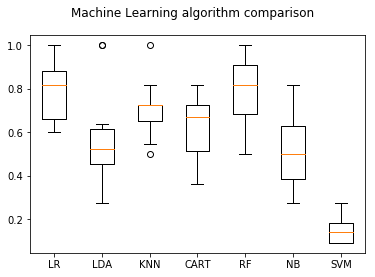

In [14]:

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
from werkzeug.wrappers import Request, Response
from flask import Flask,render_template,request
import matplotlib.pyplot as plt
app = Flask(__name__)
UPLOAD_FOLDER = os.path.basename('test')
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
global success1
success1={}
@app.route('/',methods=['POST','GET'])
def page1():
    # create the model - Random Forests
        clf  =     DecisionTreeClassifier(random_state=seed)

        # fit the training data to the model
        clf.fit(trainDataGlobal, trainLabelsGlobal)
        if request.method == 'POST':
                file1=request.files['image']
                file = os.path.join(app.config['UPLOAD_FOLDER'], file1.filename)
                image = cv2.imread(file)
                image = cv2.resize(image, fixed_size)
                fv_hu_moments = fd_hu_moments(image)
                fv_histogram  = fd_histogram(image)
                fv_texture=LBP(file)
                global_feature = np.hstack([fv_histogram,fv_hu_moments,fv_texture]).reshape(-1,1)
                scaler = MinMaxScaler(feature_range=(0, 1))
                rescaled_feature = scaler.fit_transform(global_feature)
                prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]
                cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 3)
                res=plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                success1['disease']=train_labels[prediction]
                return render_template('page2.html',result=success1,image=file)
        return render_template('page1.html')        

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 7365, app)

 * Running on http://localhost:7365/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Sep/2019 08:01:43] "GET / HTTP/1.1" 200 -
C:\Users\Harshini\Anaconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
127.0.0.1 - - [15/Sep/2019 08:01:48] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [15/Sep/2019 08:01:50] "GET / HTTP/1.1" 200 -


In [18]:
print(success1)

{}
